In [2]:
import datetime, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import script.preprocessing as prep

## Data Loading

In [46]:
# Load ess dataset.
base_dir = ''  # base directory
bank_data = pd.read_parquet(base_dir+'220701-220731_bank.parquet')  # bank data in parquet
month = 7

print(len(bank_data))
bank_data.head()

2678400


,BANK_SOC,BANK_DC_VOLT,BANK_DC_CURRENT,MAX_CELL_VOLTAGE_OF_BANK,MIN_CELL_VOLTAGE_OF_BANK,MAX_CELL_TEMPERATURE_OF_BANK,BATTERY_STATUS_FOR_CHARGE,TIMESTAMP
0,0.0,680.6,-0.7,3.343,3.316,29.5,1,2022-06-30 15:00:00
1,0.0,680.6,-0.7,3.343,3.316,29.5,1,2022-06-30 15:00:01
2,0.0,680.6,-0.5,3.343,3.316,29.5,1,2022-06-30 15:00:02
3,0.0,680.6,-0.5,3.343,3.316,29.5,1,2022-06-30 15:00:03
4,0.0,680.6,-0.5,3.343,3.316,29.5,1,2022-06-30 15:00:04


In [47]:
# Collect usable columns.
usable_columns = ['TIMESTAMP', 'BANK_DC_VOLT', 'BANK_DC_CURRENT', 'BANK_SOC', 'MAX_CELL_TEMPERATURE_OF_BANK', 'CELL_VOLTAGE_GAP', 'CHARGE_STATUS', 'DISCHARGE_STATUS']

voltage_gap = bank_data['MAX_CELL_VOLTAGE_OF_BANK'] - bank_data['MIN_CELL_VOLTAGE_OF_BANK']
charge_status = (bank_data['BATTERY_STATUS_FOR_CHARGE'] == 2)
discharge_status = (bank_data['BATTERY_STATUS_FOR_CHARGE'] == 3)

bank_data = bank_data[usable_columns[:-3]]
bank_data[usable_columns[-3]] = voltage_gap
bank_data[usable_columns[-2]] = charge_status
bank_data[usable_columns[-1]] = discharge_status

bank_data.head()

,TIMESTAMP,BANK_DC_VOLT,BANK_DC_CURRENT,BANK_SOC,MAX_CELL_TEMPERATURE_OF_BANK,CELL_VOLTAGE_GAP,CHARGE_STATUS,DISCHARGE_STATUS
0,2022-06-30 15:00:00,680.6,-0.7,0.0,29.5,0.027,False,False
1,2022-06-30 15:00:01,680.6,-0.7,0.0,29.5,0.027,False,False
2,2022-06-30 15:00:02,680.6,-0.5,0.0,29.5,0.027,False,False
3,2022-06-30 15:00:03,680.6,-0.5,0.0,29.5,0.027,False,False
4,2022-06-30 15:00:04,680.6,-0.5,0.0,29.5,0.027,False,False


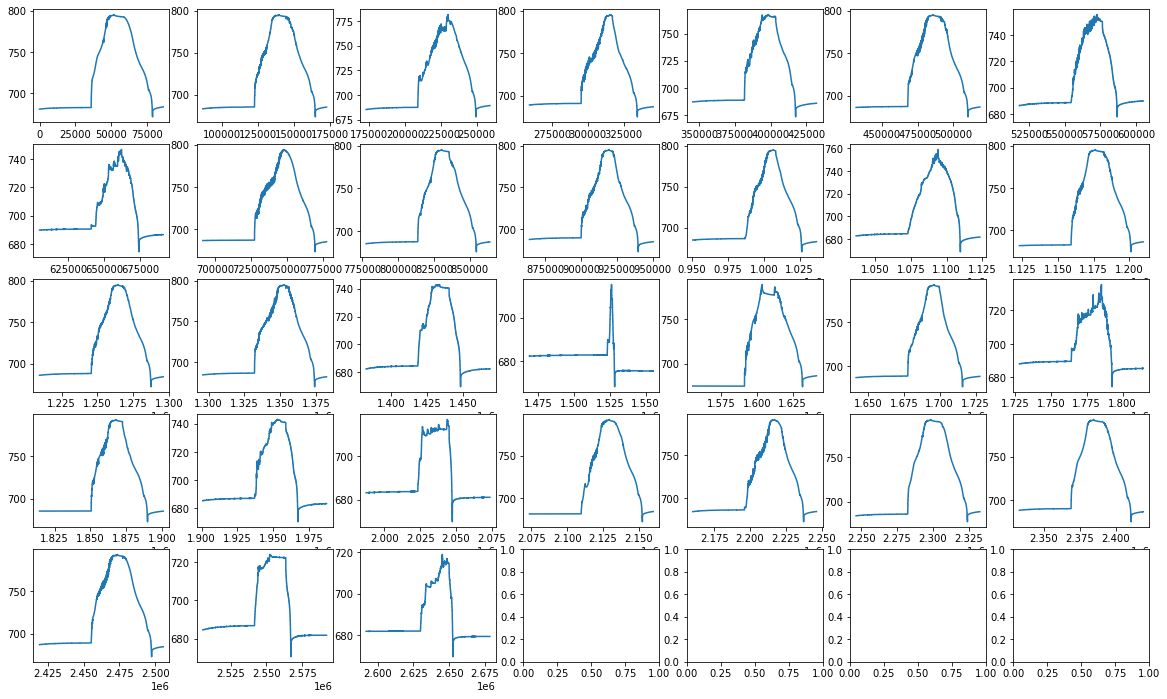

In [48]:
# Visualize daily data.
fig, axs = plt.subplots(5, 7, figsize=(20, 12))
column = usable_columns[1]
seconds_in_day = 86400

for i in range(31):
    axs[i//7, i%7].plot(bank_data[column][i*seconds_in_day:(i+1)*seconds_in_day])
fig.show()

In [10]:
series = sorted(bank_data['CELL_VOLTAGE_GAP'].unique())
print(series[0], series[-1])

0.007000000000000117 0.14800000000000013


In [68]:
bank_data.describe()

,BANK_DC_VOLT,BANK_DC_CURRENT,BANK_SOC,MAX_CELL_TEMPERATURE_OF_BANK,CELL_VOLTAGE_GAP
count,2.678400e+06,2.678400e+06,2.678400e+06,2.678400e+06,2.678400e+06
mean,7.098662e+02,3.124004e-01,1.450636e+01,2.936805e+01,5.848193e-02
std,3.553126e+01,1.213373e+02,2.262656e+01,2.229914e+00,5.613550e-02
min,6.681000e+02,-2.599000e+02,0.000000e+00,2.370000e+01,1.000000e-02
25%,6.849000e+02,-8.000000e-01,0.000000e+00,2.800000e+01,2.400000e-02
50%,6.886000e+02,-5.000000e-01,0.000000e+00,2.950000e+01,3.900000e-02
75%,7.330000e+02,-2.000000e-01,2.460000e+01,3.120000e+01,5.500000e-02
max,7.955000e+02,3.845000e+02,6.960000e+01,3.350000e+01,2.270000e-01


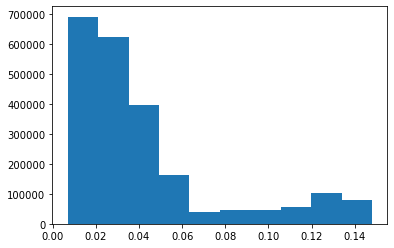

In [12]:
plt.hist(bank_data['CELL_VOLTAGE_GAP'])
plt.show()

In [50]:
# Collect data for clear days.
VOLTAGE_THRES = 790
thres_above = bank_data[['TIMESTAMP', 'BANK_DC_VOLT']][bank_data['BANK_DC_VOLT'] >= VOLTAGE_THRES]
clear_date = pd.to_datetime(thres_above['TIMESTAMP'], utc=True).dt.tz_convert('Asia/Seoul').dt.date.unique()
whole_date = pd.to_datetime(bank_data['TIMESTAMP'], utc=True).dt.tz_convert('Asia/Seoul').dt.date.unique()

invalid_date = range(6, 23)
whole_date = np.delete(whole_date, invalid_date)
clear_date = np.array([date for date in whole_date if date in clear_date])
print(whole_date)
print(clear_date, '\n')

np.random.seed(month)

test_clear_date = np.random.permutation(clear_date)[:max(1, int(0.2*len(clear_date)))]
test_cloudy_date = [date for date in whole_date if date not in clear_date]
test_cloudy_date = np.random.permutation(test_cloudy_date)[:max(1, int(0.2*len(test_cloudy_date)))]
print(test_clear_date, '\n', test_cloudy_date)

train_data = {}
test_data = {}
for date in whole_date:
    if (date in test_clear_date) or (date in test_cloudy_date):
        test_data[date] = prep.select_oneday_data(bank_data, date=date)
    else:
        train_data[date] = prep.select_oneday_data(bank_data, date=date)

[datetime.date(2022, 7, 1) datetime.date(2022, 7, 2)
 datetime.date(2022, 7, 3) datetime.date(2022, 7, 4)
 datetime.date(2022, 7, 5) datetime.date(2022, 7, 6)
 datetime.date(2022, 7, 24) datetime.date(2022, 7, 25)
 datetime.date(2022, 7, 26) datetime.date(2022, 7, 27)
 datetime.date(2022, 7, 28) datetime.date(2022, 7, 29)
 datetime.date(2022, 7, 30) datetime.date(2022, 7, 31)]
[datetime.date(2022, 7, 1) datetime.date(2022, 7, 2)
 datetime.date(2022, 7, 4) datetime.date(2022, 7, 6)
 datetime.date(2022, 7, 25) datetime.date(2022, 7, 26)
 datetime.date(2022, 7, 27) datetime.date(2022, 7, 28)
 datetime.date(2022, 7, 29)] 

[datetime.date(2022, 7, 4)] 
 [datetime.date(2022, 7, 30)]


In [72]:
print(test_data.keys())

dict_keys([datetime.date(2022, 7, 6), datetime.date(2022, 7, 8), datetime.date(2022, 7, 11), datetime.date(2022, 7, 21), datetime.date(2022, 7, 25)])


## Anomaly Synthesis

In [12]:
# Configurations for anomaly synthesis
REPLACING_RATE = (0.0005, 0.1)  # min-max rate of the length of replacing interval for anomalies

# # probabilities of anomaly types
# SOFT_REPLACING = 0.5
# UNIFORM_REPLACING = 0.25
# PEAK_NOISING = 0.15
# WHITE_NOISING = 0.1

# anomaly synthesis options
MAX_EXTERNAL_INTERVAL_RATE = 0.7
MAX_UNIFORM_VALUE_DIFFERENCE = 0.1
MIN_PEAK_ERROR = 0.1
WHITE_NOISE_LEVEL = 0.003

# data value ranges
                        # V         # I          # SOC      # temp    # gap
VALUE_RANGE = np.array([[660, 820], [-280, 410], [0, 100], [10, 40], [0, 0.2]]).transpose()

# data infos
N_COLUMNS = 5
N_ANOMALY_TYPES = 4

In [51]:
# Save training data.
base_data_dir = ''  # base directory to save data
normal_data_dir = base_data_dir + 'normal/'

for date, data in train_data.items():
    npy_data = data.iloc[:, 1:-2].to_numpy().copy()
    npy_data = np.clip((npy_data - VALUE_RANGE[[0]]) / (VALUE_RANGE[[1]] - VALUE_RANGE[[0]]), 0, 1)
    np.save(normal_data_dir+date.strftime('%y%m%d'), np.concatenate((npy_data, data.iloc[:, -2:].to_numpy()), axis=1))

In [52]:
# Synthesize single type of anomaly.
single_type_data_dir = base_data_dir + 'abnormal/'
np.random.seed(month)

# total data
total_npy_data = bank_data.iloc[:, 1:-2].to_numpy().copy()
total_npy_data = np.clip((total_npy_data - VALUE_RANGE[[0]]) / (VALUE_RANGE[[1]] - VALUE_RANGE[[0]]), 0, 1)
total_data_len = len(total_npy_data)

# meta data and anomaly label data (binary)
meta_data = []
anomaly_labels = []


for date, data in test_data.items():
    # Normalize data in [0,1].
    npy_data = data.iloc[:, 1:-2].to_numpy().copy()
    npy_data = np.clip((npy_data - VALUE_RANGE[[0]]) / (VALUE_RANGE[[1]] - VALUE_RANGE[[0]]), 0, 1)
    data_len = len(npy_data)
    
    _date = date.strftime('%y%m%d')
    anomaly_label = np.zeros((data_len,1))  # last column for anomaly index 0 or 1
    additional_data = data.iloc[:, -2:].to_numpy().copy()
    
    # Select replacing and target intervals.
    replacing_length_range = (np.array(REPLACING_RATE) * data_len).astype(int)
    replacing_lengths = np.random.randint(*replacing_length_range, size=N_ANOMALY_TYPES)
    target_indices = np.random.randint(0, data_len-replacing_lengths+1)
    
    # Select abnormal columns.
    abnormal_columns = np.random.rand(N_ANOMALY_TYPES, N_COLUMNS)
    
    
    # Synthesize anomalies. - soft replacing
    syn_data = npy_data.copy()
    _anomaly_label = anomaly_label.copy()
    interval_len = replacing_lengths[0]
    abnormal_column_idx = abnormal_columns[0] < 0.5
    if not(abnormal_column_idx.any()):
        abnormal_column_idx[np.random.randint(0, N_COLUMNS)] = True
    replacing_column_idx = np.random.choice(N_COLUMNS, size=len(abnormal_column_idx[abnormal_column_idx]), replace=False)
    
    replacing_index = np.random.randint(0, total_data_len-interval_len+1)
    external_interval = total_npy_data[replacing_index:replacing_index+interval_len, replacing_column_idx].copy()
    target_interval = syn_data[target_indices[0]:target_indices[0]+interval_len, abnormal_column_idx].copy()
    
    weights = np.concatenate((np.linspace(0, MAX_EXTERNAL_INTERVAL_RATE, num=interval_len//2),
                              np.linspace(MAX_EXTERNAL_INTERVAL_RATE, 0, num=(interval_len+1)//2)), axis=None)
    syn_data[target_indices[0]:target_indices[0]+interval_len, abnormal_column_idx] = weights[:, None] * external_interval\
                                                                                      + (1 - weights[:, None]) * target_interval
    _anomaly_label[target_indices[0]:target_indices[0]+interval_len] = 1
    syn_data = np.concatenate((syn_data, additional_data, _anomaly_label), axis=1)
    
    file_name = single_type_data_dir+_date+'_0.npy'
    meta_data.append([_date+'_0', 'replacing', (target_indices[0], target_indices[0]+interval_len),
                      tuple(np.argwhere(abnormal_column_idx).flatten()), (date in test_clear_date)])
    np.save(file_name, syn_data)
    
    
    # Synthesize anomalies. - uniform replacing
    syn_data = npy_data.copy()
    _anomaly_label = anomaly_label.copy()
    interval_len = replacing_lengths[1]
    abnormal_column_idx = abnormal_columns[1] < 0.5
    if not(abnormal_column_idx.any()):
        abnormal_column_idx[np.random.randint(0, N_COLUMNS)] = True
        
    mean_values = syn_data[target_indices[1]:target_indices[1]+interval_len, abnormal_column_idx].mean(axis=0)
    syn_data[target_indices[1]:target_indices[1]+interval_len, abnormal_column_idx]\
        = np.random.uniform(np.maximum(mean_values-MAX_UNIFORM_VALUE_DIFFERENCE, 0),
                            np.minimum(mean_values+MAX_UNIFORM_VALUE_DIFFERENCE, 1))[None, :]
    
    _anomaly_label[target_indices[1]:target_indices[1]+interval_len] = 1
    syn_data = np.concatenate((syn_data, additional_data, _anomaly_label), axis=1)
    
    file_name = single_type_data_dir+_date+'_1.npy'
    meta_data.append([_date+'_1', 'uniform', (target_indices[1], target_indices[1]+interval_len),
                      tuple(np.argwhere(abnormal_column_idx).flatten()), (date in test_clear_date)])
    np.save(file_name, syn_data)
    
    
    # Synthesize anomalies. - peak noising
    syn_data = npy_data.copy()
    _anomaly_label = anomaly_label.copy()
    interval_len = replacing_lengths[2]
    abnormal_column_idx = abnormal_columns[2] < 0.5
    if not(abnormal_column_idx.any()):
        abnormal_column_idx[np.random.randint(0, N_COLUMNS)] = True
        
    peak_indices = np.random.randint(target_indices[2], target_indices[2]+interval_len,
                                     size=len(abnormal_column_idx[abnormal_column_idx]))
    peak_values = syn_data[peak_indices, abnormal_column_idx].copy()
    
    peak_errors = np.random.uniform(np.minimum(0, MIN_PEAK_ERROR-peak_values), np.maximum(0, 1-peak_values-MIN_PEAK_ERROR))
    peak_values = peak_values + peak_errors + ((peak_errors > 0).astype(int) * 2 - 1) * MIN_PEAK_ERROR
    syn_data[peak_indices, abnormal_column_idx] = peak_values
    
    _anomaly_label[peak_indices] = 1
    syn_data = np.concatenate((syn_data, additional_data, _anomaly_label), axis=1)
    
    file_name = single_type_data_dir+_date+'_2.npy'
    meta_data.append([_date+'_2', 'peak', (np.min(peak_indices), np.max(peak_indices)+1),
                      tuple(np.argwhere(abnormal_column_idx).flatten()), (date in test_clear_date)])
    np.save(file_name, syn_data)
    
    
    # Synthesize anomalies. - white noising
    syn_data = npy_data.copy()
    _anomaly_label = anomaly_label.copy()
    interval_len = replacing_lengths[3]
    abnormal_column_idx = abnormal_columns[3] < 0.5
    if not(abnormal_column_idx.any()):
        abnormal_column_idx[np.random.randint(0, N_COLUMNS)] = True
        
    noised_data = syn_data[target_indices[3]:target_indices[3]+interval_len, abnormal_column_idx]\
                  + np.random.randn(interval_len, len(abnormal_column_idx[abnormal_column_idx])) * WHITE_NOISE_LEVEL
    noised_data[noised_data > 1] = 1
    noised_data[noised_data < 0] = 0
    syn_data[target_indices[3]:target_indices[3]+interval_len, abnormal_column_idx] = noised_data
    
    _anomaly_label[target_indices[3]:target_indices[3]+interval_len] = 1
    syn_data = np.concatenate((syn_data, additional_data, _anomaly_label), axis=1)
    
    file_name = single_type_data_dir+_date+'_3.npy'
    meta_data.append([_date+'_3', 'white_noise', (target_indices[3], target_indices[3]+interval_len),
                      tuple(np.argwhere(abnormal_column_idx).flatten()), (date in test_clear_date)])
    np.save(file_name, syn_data)

In [53]:
# Save meta data.
meta_data = pd.DataFrame(meta_data, columns=['name', 'type', 'abnormal_interval', 'abnormal_column', 'clear_date'])
meta_data.to_csv(single_type_data_dir+'meta_data_'+_date[:-2]+'.csv')
meta_data.head()

,name,type,abnormal_interval,abnormal_column,clear_date
0,220704_0,replacing,"(79463, 80043)","(0, 1, 2)",True
1,220704_1,uniform,"(56718, 62460)","(0, 1, 2, 4)",True
2,220704_2,peak,"(68211, 70971)","(0, 2)",True
3,220704_3,white_noise,"(53593, 54555)","(0, 3)",True
4,220730_0,replacing,"(38105, 38893)","(0, 1, 2, 3)",False


In [63]:
# Merge all data.
meta_dataset = []
abnormal_dataset = []
for file in sorted(os.listdir(single_type_data_dir)):
    if 'meta' in file:
        meta_dataset.append(pd.read_csv(single_type_data_dir+file).iloc[:, 1:])
    elif '.npy' in file:
        abnormal_dataset.append(np.load(single_type_data_dir+file))
        
meta_dataset = pd.concat(meta_dataset)
abnormal_dataset = np.concatenate(abnormal_dataset, axis=0)

meta_dataset.to_csv(single_type_data_dir+'meta_data.csv')
np.save(single_type_data_dir+'total_2202-2207.npy', abnormal_dataset)

In [65]:
normal_dataset = []
for file in sorted(os.listdir(normal_data_dir)):
    if '.npy' in file:
        normal_dataset.append(np.load(normal_data_dir+file))
        
normal_dataset = np.concatenate(normal_dataset, axis=0)
np.save(normal_data_dir+'total_2202-2207.npy', normal_dataset)